# Opening a Restaurant in Long Beach Island, NJ
Analyzing Yelp data to open a restaurant

**Author:** James Hodgens
***

## Overview

The purpose of this project was to use exploratory data analysis to generate insights regarding opening a restaurant in the Long Beach Island area located on the Jersey Shore. Data obtained from Yelp's API was leveraged to conduct the analysis. 

## Business Problem

The primary objective was to answer two questions - 1) Where specifically in the LBI region should the restaurant be located? and 2) What type of restaurant should it be (i.e. what category of cuisine)?

In [1]:
#import packages
import pandas as pd
import requests
import json
import os.path
from os import path
import csv
import numpy as np
import matplotlib.pyplot as plt
import folium
import ast

In [2]:
#yelp credentials
yelp_id = "4eucNo6rT7PNhkEzgMEKJQ"
yelp_key = "7bG0ESSZL3r562AjGaZ-C2NFWWlOuwXiMJPb_xI0mUiziEKXWS9DVhiM_t4Jk0xdqLHc1qsKtDqdhrPRut4sHlmFac3p0rKuBKm3vUhAW0Vhb33NFzVaAaE7nXOaYHYx"

## Data Understanding

Yelp data was reviewed for existing restaurants in the LBI region including the:

- Ratings

- Number of reviews

- Restaurant categories

- Locations

In [3]:
#data acquisition process
#define yelp call function
def yelp_call(url_params, api_key):
    headers = {'Authorization': 'Bearer ' + api_key}
    response = requests.get('https://api.yelp.com/v3/businesses/search', headers=headers, params=url_params)
    data = response.json()
    return data

In [4]:
#select data from yelp api needed for analysis
all_categories = ['id', 'name', 'is_closed', 'url', 'review_count', 'categories', 
                  'rating', 'latitude', 'longitude', 'address1', 'address2', 
                  'address3', 'city', 'state', 'zip_code', 'price']

In [5]:
#define function to parse yelp data for above categories
def parse_results(results):
    parsed_data=[]
    for business in results['businesses']:
        if 'price' not in business:
            business['price'] = None
        business_data = [business['id'], business['name'], business['is_closed'], business['url'], 
                         business['review_count'], business['categories'], business['rating'], 
                         business['coordinates']['latitude'], business['coordinates']['longitude'], 
                         business['location']['address1'], business['location']['address2'], 
                         business['location']['address3'], business['location']['city'], 
                         business['location']['state'], business['location']['zip_code'], business['price']]
        business_data_zip = dict(zip(all_categories, business_data))
        parsed_data.append(business_data_zip)
    return parsed_data

In [6]:
#define function to save csv file containing yelp info and append additional data
def df_save(csv_filepath, parsed_results):
    parsed_df = pd.DataFrame(parsed_results)
    if path.exists(csv_filepath) == False:
        parsed_df.to_csv(csv_filepath, header=True)
    else:
        with open(csv_filepath, 'a') as f:
            parsed_df.to_csv(f, header=False)

In [7]:
#define parameters for yelp call
url_params = {
    'term': 'restaurant',
    'location': 'Long+Beach+Island+NJ',
    'limit': 50,
    'offset': 0}
api_key = yelp_key

In [8]:
# loop over functions to get data and save as csv
cur = 0
while cur < 250:
    url_params['offset'] = cur
    results = yelp_call(url_params, api_key)
    parsed_results = parse_results(results)
    df_save('yelp_businesses.csv', parsed_results)
    cur += 50

## Data Preparation

Data was pulled using the Yelp API for business information. Two-hundred restaurants in the LBI region were analyzed as part of this exercise and were grouped by location and type of restaurant.

In [10]:
#open csv and begin to look at data
df = pd.read_csv('yelp_businesses.csv')
df.head()

,Unnamed: 0,id,name,is_closed,url,review_count,categories,rating,latitude,longitude,address1,address2,address3,city,state,zip_code,price
0,0,QKhSd92X3EF8fComzbA45w,The Chicken or the Egg,False,https://www.yelp.com/biz/the-chicken-or-the-eg...,912,"[{'alias': 'tradamerican', 'title': 'American ...",4.5,39.564671,-74.238966,207 N Bay Ave,NaN,NaN,Beach Haven,NJ,8008,$$
1,1,YVERvPBMurED_1yWtigJQw,Salt Kitchen & Bar,False,https://www.yelp.com/biz/salt-kitchen-and-bar-...,72,"[{'alias': 'newamerican', 'title': 'American (...",4.0,39.652724,-74.182748,350 W 8th St,NaN,NaN,Ship Bottom,NJ,8008,NaN
2,2,uMNgVdpOI22QFTkxaVo9sA,The Beach House Restaurant,False,https://www.yelp.com/biz/the-beach-house-resta...,101,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.0,39.585813,-74.223744,13015 Long Beach Blvd,NaN,NaN,Beach Haven Terrace,NJ,8008,$$$
3,3,fstH18hKRdg5LLtocV8G_A,The Arlington,False,https://www.yelp.com/biz/the-arlington-ship-bo...,344,"[{'alias': 'newamerican', 'title': 'American (...",3.5,39.646470,-74.177979,1302 Long Beach Blvd,NaN,NaN,Ship Bottom,NJ,8008,$$$
4,4,uBMQXMgvK1iVdmS4CglCKA,Ship Bottom Shellfish,False,https://www.yelp.com/biz/ship-bottom-shellfish...,294,"[{'alias': 'seafood', 'title': 'Seafood'}]",4.0,39.644334,-74.180282,1721 Long Beach Blvd,NaN,NaN,Ship Bottom,NJ,8008,$$


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    200 non-null    int64  
 1   id            200 non-null    object 
 2   name          200 non-null    object 
 3   is_closed     200 non-null    bool   
 4   url           200 non-null    object 
 5   review_count  200 non-null    int64  
 6   categories    200 non-null    object 
 7   rating        200 non-null    float64
 8   latitude      200 non-null    float64
 9   longitude     200 non-null    float64
 10  address1      199 non-null    object 
 11  address2      7 non-null      object 
 12  address3      4 non-null      object 
 13  city          200 non-null    object 
 14  state         200 non-null    object 
 15  zip_code      200 non-null    int64  
 16  price         151 non-null    object 
dtypes: bool(1), float64(3), int64(3), object(10)
memory usage: 25.3+ KB


In [12]:
#display restaurants on map
locationlist = df[['latitude', 'longitude']].values.tolist()
map = folium.Map(location = [39.7, -74.2])
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['name'][point]).add_to(map)
map

In [13]:
#Identify areas to open a restaurant in LBI region based on map
mainland_towns = ['Barnegat', 'Eagleswood', 'Little Egg Harbor Twp', 'Manahawkin', 'Stafford Township', 'West Creek']
area = []
for num, city in enumerate(df['city']):
    if city in mainland_towns:
        area.append('mainland')
    elif df['latitude'][num] > 39.6:
        area.append('island-north')
    else:
        area.append('island-south')

In [14]:
#Add area to dataframe
df['area'] = area

In [15]:
#Number of restaurants in each area
df.groupby('area').count()['id']

area
island-north    65
island-south    68
mainland        67
Name: id, dtype: int64

In [17]:
#create a new dataframe containing the type of restaurants (category)
output = []
for num, restaurant in enumerate(df['categories']):
    for category in ast.literal_eval(restaurant):
        temp_list = [df['id'][num], category['alias'], category['title'], 
                     df['rating'][num], df['review_count'][num], df['area'][num]]
        output.append(temp_list)
        
category_df = pd.DataFrame(output)

category_df.rename(columns = {0:'business_id', 1:'alias', 
                              2:'title', 3: 'rating', 
                              4: 'review_count', 5: 'area'}, inplace = True)

category_df

,business_id,alias,title,rating,review_count,area
0,QKhSd92X3EF8fComzbA45w,tradamerican,American (Traditional),4.5,912,island-south
1,QKhSd92X3EF8fComzbA45w,breakfast_brunch,Breakfast & Brunch,4.5,912,island-south
2,QKhSd92X3EF8fComzbA45w,burgers,Burgers,4.5,912,island-south
3,YVERvPBMurED_1yWtigJQw,newamerican,American (New),4.0,72,island-north
4,YVERvPBMurED_1yWtigJQw,bars,Bars,4.0,72,island-north
...,...,...,...,...,...,...
427,GaPMgtqB7VOtTy_22IVaPA,pretzels,Pretzels,2.5,7,mainland
428,GaPMgtqB7VOtTy_22IVaPA,hotdog,Hot Dogs,2.5,7,mainland
429,zdDGGZlW937ACVmbedGrBA,chinese,Chinese,2.0,22,mainland
430,78UO-Qgt-Ja0RFIRHWxPDg,delis,Delis,1.0,1,island-south


In [18]:
#Find list of restaurant types and count
print('There are ',len(set(category_df['title'])),' restaurant categories:',
      set(category_df['title'])

)

There are  70  restaurant categories: {'Bars', 'Pizza', 'Tex-Mex', 'Creperies', 'Cheesesteaks', 'Empanadas', 'Cafes', 'Chicken Wings', 'Chinese', 'Hawaiian', 'Italian', 'Sushi Bars', 'Desserts', 'Japanese', 'Vegetarian', 'Barbeque', 'Cocktail Bars', 'Hot Dogs', 'Tiki Bars', 'Restaurants', 'Juice Bars & Smoothies', 'Food Trucks', 'Sports Bars', 'Seafood Markets', 'Ice Cream & Frozen Yogurt', 'Pubs', 'Tapas Bars', 'Beer, Wine & Spirits', 'Coffee & Tea', 'Vegan', 'Diners', 'Salad', 'Bed & Breakfast', 'Soup', 'Pretzels', 'Beer Gardens', 'Waffles', 'Noodles', 'Mexican', 'Seafood', 'Grocery', 'Lounges', 'Burgers', 'Venues & Event Spaces', 'Art Galleries', 'Fast Food', 'Beer Bar', 'Caterers', 'Sandwiches', 'Steakhouses', 'Bagels', 'Bubble Tea', 'Kebab', 'Asian Fusion', 'Gastropubs', 'Butcher', 'Latin American', 'French', 'Mediterranean', 'Breakfast & Brunch', 'American (New)', 'Caribbean', 'Chicken Shop', 'Bakeries', 'Delis', 'Donuts', 'Wraps', 'American (Traditional)', 'Resorts', 'Poke'}


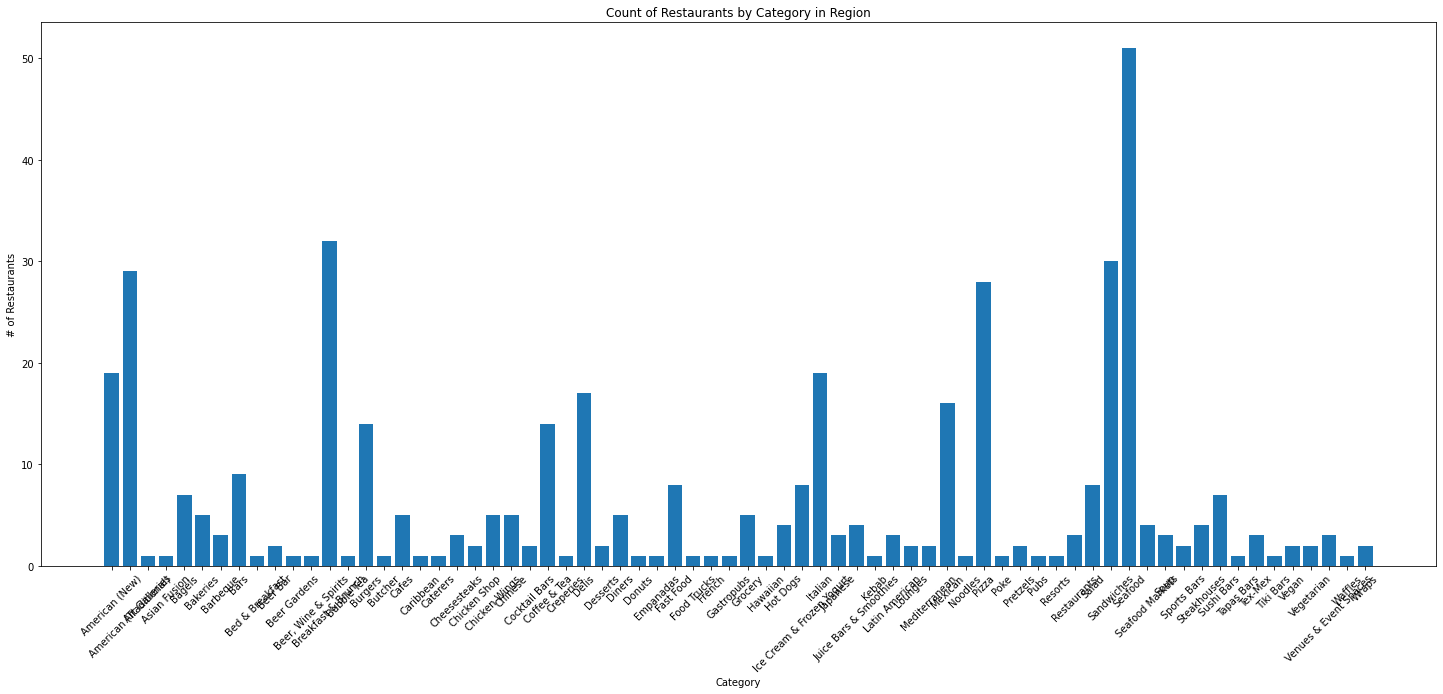

In [20]:
#Plot count by category
count_df = category_df.groupby('title').count()['business_id']
count_df = count_df.reset_index()
count_df.rename(columns = {'title':'restaurant_category','business_id': 'restaurant_count'}, inplace = True)
figure, ax = plt.subplots(figsize=(25,10))
ax.bar(count_df['restaurant_category'], count_df['restaurant_count'])
ax.set_xlabel('Category')
ax.set_ylabel('# of Restaurants')
ax.set_title('Count of Restaurants by Category in Region')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

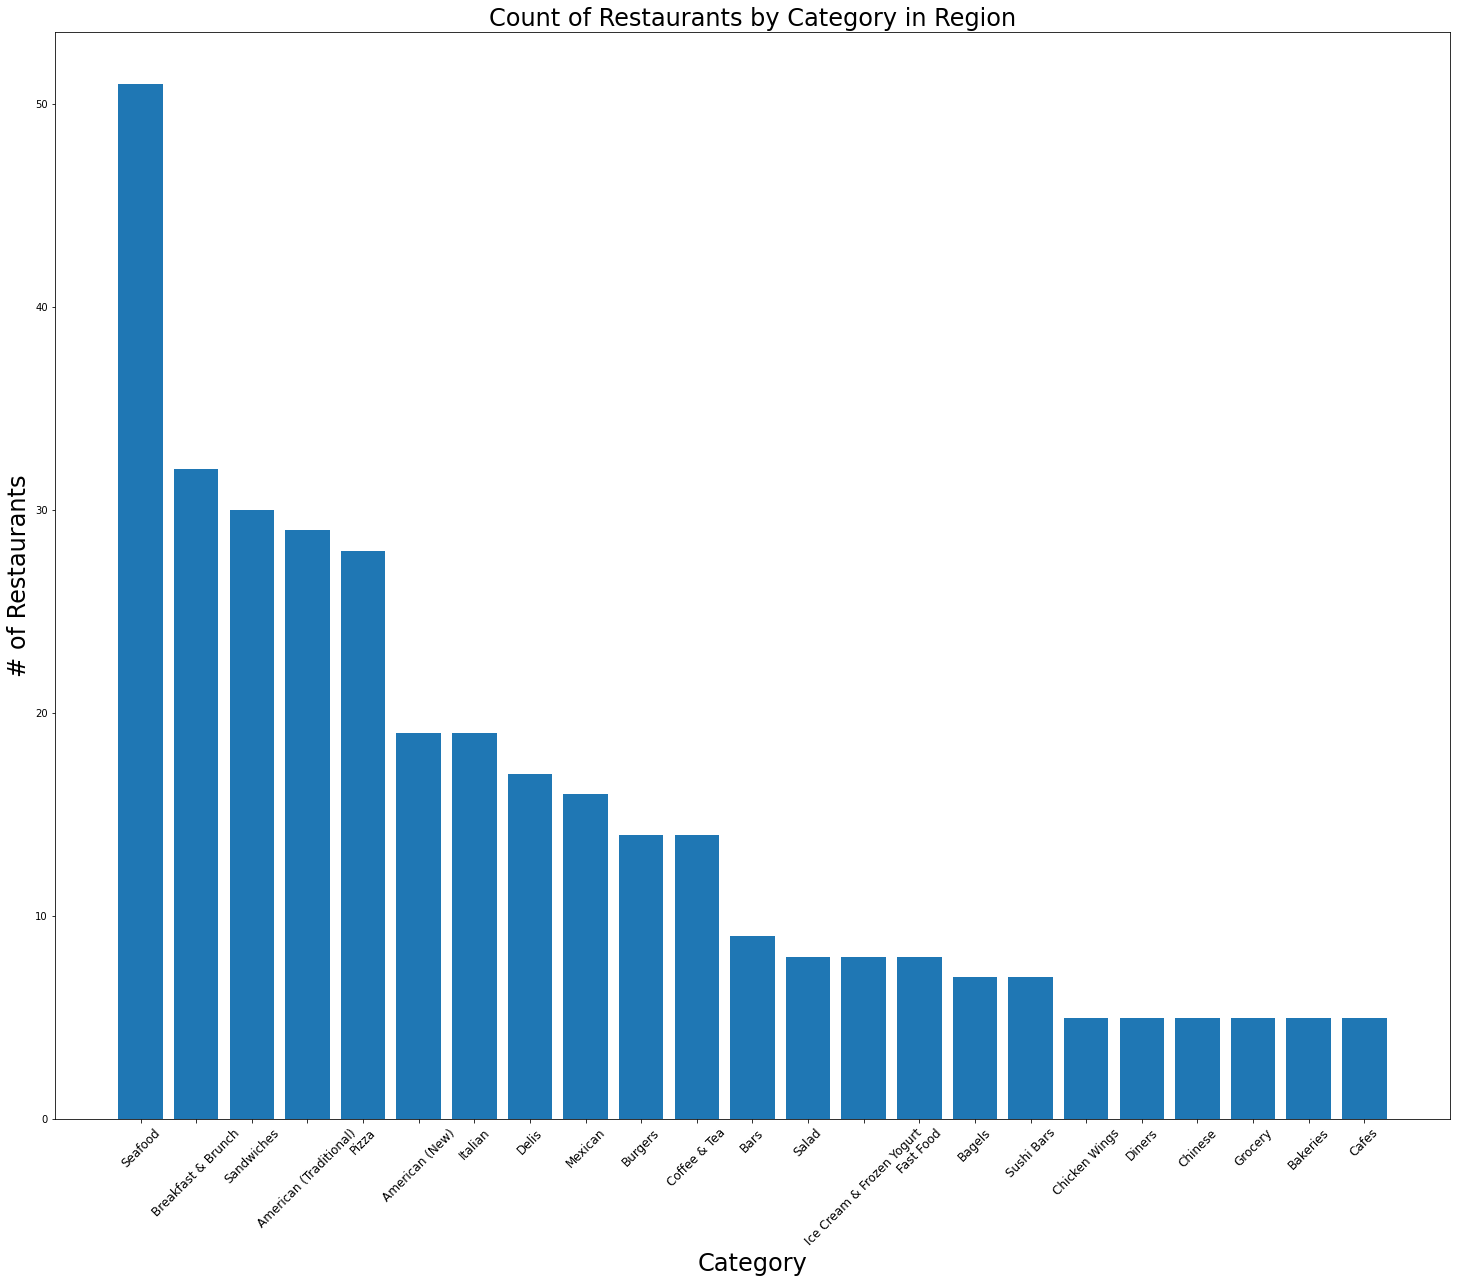

In [38]:
#Find top categories by number of restaurants
top_categories_df = count_df.sort_values('restaurant_count', ascending=False)[0:23]
top_categories = top_categories_df.reset_index()
top_categories.drop('index', axis=1, inplace = True)
figure, ax = plt.subplots(figsize=(25,20))
ax.bar(top_categories_df['restaurant_category'], top_categories_df['restaurant_count'])
ax.set_xlabel('Category', fontsize=24)
ax.set_ylabel('# of Restaurants', fontsize=24)
ax.set_title('Count of Restaurants by Category in Region', fontsize=24)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.rc('xtick', labelsize=10) 

In [39]:
top_categories

,restaurant_category,restaurant_count
0,Seafood,51
1,Breakfast & Brunch,32
2,Sandwiches,30
3,American (Traditional),29
4,Pizza,28
5,American (New),19
6,Italian,19
7,Delis,17
8,Mexican,16
9,Burgers,14


In [40]:
#Find average rating and number of reviews by restaurant type
top_category_list = list(top_categories['restaurant_category'])
average_df = average_df = category_df.groupby('title').mean()
average_df.reset_index(inplace = True)
top_average_df = average_df.loc[average_df['title'].isin(top_category_list)]
top_average_df.reset_index(inplace = True)
top_average_df = top_average_df.drop('index', axis=1)
top_average_df

,title,rating,review_count
0,American (New),3.842105,110.105263
1,American (Traditional),3.568966,124.724138
2,Bagels,3.714286,62.571429
3,Bakeries,2.900000,14.000000
4,Bars,3.388889,156.333333
5,Breakfast & Brunch,3.734375,96.875000
6,Burgers,3.642857,130.785714
7,Cafes,4.000000,8.000000
8,Chicken Wings,3.200000,49.200000
9,Chinese,3.200000,27.400000


## Data Analysis
The restaurant data was analyzed in order to identify what area and category of restaurant would be best to open in the LBI region.

Text(0.5, 1.0, 'Average reviews and rating by category')

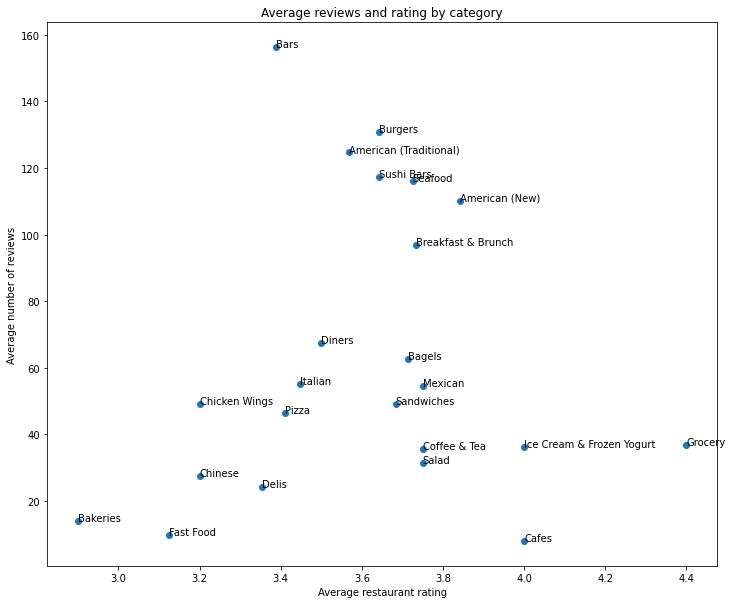

In [42]:
#Plot average rating and average number of reviews for the top categories
figure, ax = plt.subplots(figsize=(12,10))
ax.scatter(top_average_df['rating'], top_average_df['review_count'])
for i, label in enumerate(top_average_df['title']):
    plt.annotate(label, (top_average_df['rating'][i], top_average_df['review_count'][i]))
ax.set_xlabel('Average restaurant rating')
ax.set_ylabel('Average number of reviews')
ax.set_title('Average reviews and rating by category')

In [76]:
#Group by area and category
category_area_df = category_df.groupby(['title', 'area']).count()['business_id'].reset_index()
top_category_area_df = category_area_df.loc[category_area_df['title'].isin(['Seafood', 'American (New)', 
                                                                            'American (Traditional)', 'Sushi Bars', 
                                                                           'Breakfast & Brunch', 'Burgers'])]
top_category_area_df = top_category_area_df.reset_index()
top_category_area_df.drop('index', axis=1, inplace = True)
top_category_area_df

,title,area,business_id
0,American (New),island-north,13
1,American (New),island-south,4
2,American (New),mainland,2
3,American (Traditional),island-north,8
4,American (Traditional),island-south,14
5,American (Traditional),mainland,7
6,Breakfast & Brunch,island-north,14
7,Breakfast & Brunch,island-south,11
8,Breakfast & Brunch,mainland,7
9,Burgers,island-north,6


In [77]:
#Pivot df to set up bar graph
pivot_df = pd.pivot_table(top_category_area_df, values='business_id', index='area', columns='title', aggfunc=np.sum)
pivot_df

title,American (New),American (Traditional),Breakfast & Brunch,Burgers,Seafood,Sushi Bars
area,,,,,,
island-north,13,8,14,6,16,3
island-south,4,14,11,4,27,2
mainland,2,7,7,4,8,2


Text(0.5, 1.0, 'Number of restaurants in each location by category')

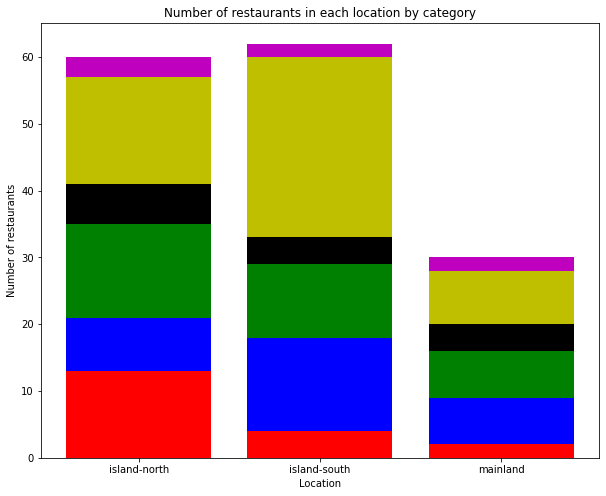

In [94]:
#Plot stacked bar graph
x = ['island-north', 'island-south', 'mainland']
y1 = pivot_df['American (New)']
y2 = pivot_df['American (Traditional)']
y3 = pivot_df['Breakfast & Brunch']
y4 = pivot_df['Burgers']
y5 = pivot_df['Seafood']
y6 = pivot_df['Sushi Bars']
figure, ax = plt.subplots(figsize=(10, 8))
ax.bar(x, y1, color = 'r')
ax.bar(x, y2, bottom = y1, color = 'b')
ax.bar(x, y3, bottom = y1+y2, color = 'g')
ax.bar(x, y4, bottom = y1+y2+y3, color = 'k')
ax.bar(x, y5, bottom = y1+y2+y3+y4, color = 'y')
ax.bar(x, y6, bottom = y1+y2+y3+y4+y5, color = 'm')
ax.set_xlabel('Location')
ax.set_ylabel('Number of restaurants')
ax.set_title('Number of restaurants in each location by category')

In [88]:
#Updaing bar graph to only show restaurants with a rating greater than 3.5
top_half = category_df[category_df['rating']>3.5]
best_top_half = top_half.loc[top_half['title'].isin(['Seafood', 'American (New)', 'American (Traditional)', 
                                             'Sushi Bars', 'Breakfast & Brunch', 'Burgers'])]
best_top_half_grouped = best_top_half.groupby(['title', 'area']).count()['business_id'].reset_index()
best_top_half_grouped

,title,area,business_id
0,American (New),island-north,7
1,American (New),island-south,3
2,American (New),mainland,1
3,American (Traditional),island-north,3
4,American (Traditional),island-south,7
5,American (Traditional),mainland,1
6,Breakfast & Brunch,island-north,9
7,Breakfast & Brunch,island-south,7
8,Breakfast & Brunch,mainland,3
9,Burgers,island-north,4


In [89]:
#Update with missing values
best_top_half_grouped.loc[15,'title']='Burgers'
best_top_half_grouped.loc[15,'area']='mainland'
best_top_half_grouped.loc[15,'business_id']=0
best_top_half_grouped.loc[16,'title']='Sushi Bars'
best_top_half_grouped.loc[16,'area']='mainland'
best_top_half_grouped.loc[16,'business_id']=0
best_top_half_grouped.loc[17,'title']='Sushi Bars'
best_top_half_grouped.loc[17,'area']='island-south'
best_top_half_grouped.loc[17,'business_id']=0

In [90]:
top_pivot_df = pd.pivot_table(best_top_half_grouped, 
                              values='business_id', index='area', columns='title', aggfunc=np.sum)

In [91]:
top_pivot_df

title,American (New),American (Traditional),Breakfast & Brunch,Burgers,Seafood,Sushi Bars
area,,,,,,
island-north,7.0,3.0,9.0,4.0,9.0,2.0
island-south,3.0,7.0,7.0,3.0,12.0,0.0
mainland,1.0,1.0,3.0,0.0,6.0,0.0


Text(0.5, 1.0, 'Number of top restaurants (>3.5 rating) in each location by category')

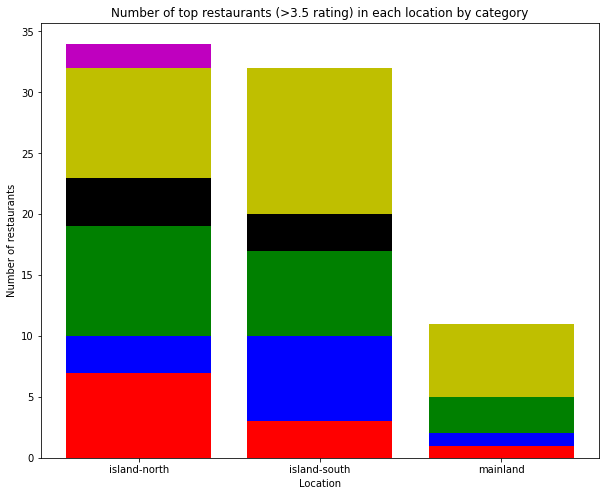

In [95]:
#Plot updated bar graph
x = ['island-north', 'island-south', 'mainland']
y1 = top_pivot_df['American (New)']
y2 = top_pivot_df['American (Traditional)']
y3 = top_pivot_df['Breakfast & Brunch']
y4 = top_pivot_df['Burgers']
y5 = top_pivot_df['Seafood']
y6 = top_pivot_df['Sushi Bars']
figure, ax = plt.subplots(figsize=(10, 8))
ax.bar(x, y1, color = 'r')
ax.bar(x, y2, bottom = y1, color = 'b')
ax.bar(x, y3, bottom = y1+y2, color = 'g')
ax.bar(x, y4, bottom = y1+y2+y3, color = 'k')
ax.bar(x, y5, bottom = y1+y2+y3+y4, color = 'y')
ax.bar(x, y6, bottom = y1+y2+y3+y4+y5, color = 'm')
ax.set_xlabel('Location')
ax.set_ylabel('Number of restaurants')
ax.set_title('Number of top restaurants (>3.5 rating) in each location by category')

## Conclusions
There may be an opportunity to open a sushi restaurant in the southern part of LBI or on the mainland.